# Importing and Transforming Data

In [2]:
#import dataset
import pandas as pd

df = pd.read_csv("source_data.csv", sep = ",")

#Perform transformations
df["trip_id"] = df["trip_id"].astype('category')
df["origin_warehouse_code"] = df["origin_warehouse_code"].astype('category')
df["destination_warehouse_code"] = df["destination_warehouse_code"].astype('category')

df["total_quantity"] = df["total_quantity"].astype('float')

df["trip_created_date"] = pd.to_datetime(df["trip_created_date"])
df["trip_start_time"] = pd.to_datetime(df["trip_start_time"])
df["geofence_in_time"] = pd.to_datetime(df["geofence_in_time"])
df["geofence_out_time"] = pd.to_datetime(df["geofence_out_time"])

df = df.dropna(how='any',axis=0) 

#drop outliers
df = df[df["drop_sequence"] > 0]
df = df[df["distance_calculated"] > 0]
df = df[df["distance_covered_till_drop"] > 0]
df = df[df["total_quantity"] > 0]
df = df[df["actual_transit_time_from_cnf_minutes"] > 0]

cols = ['drop_sequence', 'distance_calculated','distance_covered_till_drop', 'total_quantity', 'actual_transit_time_from_cnf_minutes']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

#feature engineering
df[["year", "month", "m_day", "hour"]] = df["trip_start_time"].apply(lambda x: x.timetuple()[0:4]).tolist()

df["w_day"] = df["geofence_out_time"].apply(lambda x: x.weekday())

#Define columns based on feature engineering
# cols = ['drop_sequence', 'distance_calculated','distance_covered_till_drop', 'origin_warehouse_code',
#            'destination_warehouse_code', 'total_quantity', 'trip_start_time']

cols = ['drop_sequence', 'distance_calculated','distance_covered_till_drop', 'origin_warehouse_code',
           'destination_warehouse_code', 'total_quantity', 'trip_start_time', 'year', 'month', 'm_day', 'hour', 'w_day']

# Splitting and Encoding Data

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# df["actual_transit_time_from_cnf_minutes"] = le.fit_transform(df["actual_transit_time_from_cnf_minutes"])

# df['trip_start_time'] = le.fit_transform(df['trip_start_time'])
# df['origin_warehouse_code'] = le.fit_transform(df['origin_warehouse_code'])
# df['destination_warehouse_code'] = le.fit_transform(df['destination_warehouse_code'])

#Split dataset
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['actual_transit_time_from_cnf_minutes'], test_size=0.1, random_state=31)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


y_train = le.fit_transform(y_train)

X_train['trip_start_time'] = le.fit_transform(X_train['trip_start_time'])
X_train['origin_warehouse_code'] = le.fit_transform(X_train['origin_warehouse_code'])
X_train['destination_warehouse_code'] = le.fit_transform(X_train['destination_warehouse_code'])

y_test = le.fit_transform(y_test)

X_test['trip_start_time'] = le.fit_transform(X_test['trip_start_time'])
X_test['origin_warehouse_code'] = le.fit_transform(X_test['origin_warehouse_code'])
X_test['destination_warehouse_code'] = le.fit_transform(X_test['destination_warehouse_code'])


# Simple Feature Importance

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train[cols], y_train) 

In [5]:
preds = model.predict(X_test[cols])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_train, model.predict(X_train[cols]))

print(mse)
print(mae)
print(rmse)
print(r2)

6636380.151070174
2217.942741679638
2576.117262678501
0.8205743826298417


In [6]:
print(model.score(X_train, y_train))

0.8205743826298417


In [7]:
model.score(X_test, y_test)

-208.87089855936037

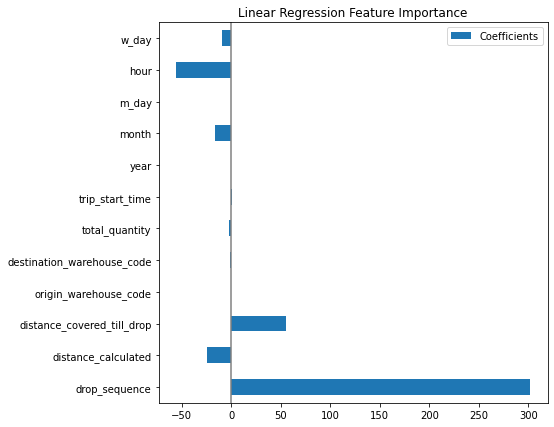

In [16]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=X_train.columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Linear Regression Feature Importance")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# XGBoost

In [9]:
#Importing machine learning algorithms
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [10]:
model_xgb = xgb.XGBRegressor(objective='reg:squaredlogerror')
model_xgb.fit(X_train[cols], y_train)

preds = model_xgb.predict(X_test[cols])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_train, model_xgb.predict(X_train[cols]))

print(mse)
print(mae)
print(rmse)
print(r2)

55828.409852336394
193.04333372239944
236.28036281573716
-2.568771289529553


In [11]:
model_xgb.save_model('model_xgb_fe_out.model')

# LightGBM

In [12]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train[cols], y_train)

preds = model_lgb.predict(X_test[cols])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_train, model_lgb.predict(X_train[cols]))

print(mse)
print(mae)
print(rmse)
print(r2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 5540, number of used features: 10
[LightGBM] [Info] Start training from score 2693.378700
6929542.9149466
2323.558618055709
2632.402498659086
0.9388698988228197


In [13]:
model_lgb.booster_.save_model('model_lgb_fe_out.txt')

# CatBoost

In [14]:
import catboost as cb

model_cb = cb.CatBoostRegressor()
model_cb.fit(X_train[cols], y_train)

preds = model_cb.predict(X_test[cols])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_train, model_cb.predict(X_train[cols]))

print(mse)
print(mae)
print(rmse)
print(r2)

Learning rate set to 0.05366
0:	learn: 1520.3498136	total: 160ms	remaining: 2m 39s
1:	learn: 1459.5865977	total: 170ms	remaining: 1m 24s
2:	learn: 1400.5723763	total: 178ms	remaining: 59.2s
3:	learn: 1344.2982196	total: 182ms	remaining: 45.4s
4:	learn: 1291.9979782	total: 186ms	remaining: 37s
5:	learn: 1243.5449745	total: 189ms	remaining: 31.4s
6:	learn: 1196.2148405	total: 193ms	remaining: 27.4s
7:	learn: 1152.6244407	total: 220ms	remaining: 27.3s
8:	learn: 1113.8007597	total: 227ms	remaining: 25s
9:	learn: 1075.0795358	total: 231ms	remaining: 22.9s
10:	learn: 1039.3064352	total: 235ms	remaining: 21.1s
11:	learn: 1005.2347955	total: 240ms	remaining: 19.8s
12:	learn: 973.7941453	total: 245ms	remaining: 18.6s
13:	learn: 946.5684082	total: 249ms	remaining: 17.5s
14:	learn: 919.6639913	total: 253ms	remaining: 16.6s
15:	learn: 893.1100541	total: 256ms	remaining: 15.8s
16:	learn: 869.4781426	total: 260ms	remaining: 15s
17:	learn: 847.4740655	total: 263ms	remaining: 14.3s
18:	learn: 827.6751

In [15]:
model_cb.save_model("model_cb", format="cbm")